In [ ]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
latt_size = (16, 16, 16, 16)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
# mass = 0.05
# mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
clover_term = torch.zeros_like(clover_term) # just for test

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True


    @@@@@@######QCU NOTES START######@@@@@@@
    Guide:
    0. Required: MPI(e.g. 4.1.2), CUDA(e.g. 12.4), CMAKE(e.g. 3.22.1), GCC(e.g. 11.4.0), HDF5-MPI(e.g. 1.10.7,'apt install libhdf5-mpi-dev && export HDF5_MPI="ON" && pip install --no-binary=h5py h5py').
    1. The libqcu.so was compiled when pyqcu setup in download_path/PyQCU/lib, please add this path to your LD_LIBRARY_PATH.
    2. The QCU(PyQCU) splite grid by x->y->z->t, lattice by x->y->z->t->p->d[x,y,z,t]->c->c or x->y->z->t->c->s(->p) and x->y->z->t->c->s->c->s(->p).
    3. The QUDA(PyQUDA) splite grid by t->z->y->x, lattice by c->c->x->y->z->t->p->d[x,y,z,t] or c->s->x->y->z->t(->p) and c->s->c->s->x->y->z->t(->p).
    4. The QCU input params in numpy array(dtype=np.int32), argv in  numpy array(dtype=np.float32 or float64) array, set_ptrs in numpy array(dtype=np.int64), other in cupy array(dtype=cp.complex64 or complex128).
    5. The smallest lattice size is (wilson:x=4,y=4,z=4,t=4;clover:x=8,y=8,z=8,t=8) that QCU support

In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.1685346641519847e-16


In [ ]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U=U,
                clover=clover, clover_term=clover.add_I(clover_term=clover_term), verbose=verbose, max_iter=20, max_levels=2)

self.dof_list:[12, 96, 12, 12, 4, 4, 4, 24, 12, 12, 12, 24, 24, 24, 24, 48, 48, 24, 8, 8, 8, 4, 12, 12, 12, 8, 4, 2, 4, 4, 24, 12, 12, 12, 4, 4, 4, 4, 4]
Building grid list:
  Level 0: 8x8x8x16
  Level 1: 4x4x4x8
self.grid_list:[[16, 8, 8, 8], [8, 4, 4, 4]]
Norm of b:352.3651147003312
Norm of r:498.7245661432031
Norm of x0:314.4765596743291
BICGSTAB-Iteration 0: Residual = 8.597064e+01, Time = 0.007420 s
BICGSTAB-Iteration 1: Residual = 2.815424e+01, Time = 0.006562 s
BICGSTAB-Iteration 2: Residual = 4.690536e+01, Time = 0.006809 s
BICGSTAB-Iteration 3: Residual = 9.501896e+00, Time = 0.006503 s
BICGSTAB-Iteration 4: Residual = 5.874192e+00, Time = 0.006745 s
BICGSTAB-Iteration 5: Residual = 6.885172e+00, Time = 0.006719 s
BICGSTAB-Iteration 6: Residual = 5.885222e+00, Time = 0.006959 s
BICGSTAB-Iteration 7: Residual = 3.838094e+00, Time = 0.007152 s
BICGSTAB-Iteration 8: Residual = 3.573207e+00, Time = 0.006842 s
BICGSTAB-Iteration 9: Residual = 4.511493e+00, Time = 0.006269 s
BICGSTA

In [ ]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [ ]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 5.42 ms, sys: 0 ns, total: 5.42 ms
Wall time: 4.66 ms
CPU times: user 1.78 ms, sys: 0 ns, total: 1.78 ms
Wall time: 1.62 ms
313.53468707624677
0.0
351.18441559923684
351.18441559923684
1.3954356222581958e-16
CPU times: user 33.8 ms, sys: 10 μs, total: 33.8 ms
Wall time: 32.6 ms


In [ ]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 5.9 ms, sys: 326 μs, total: 6.22 ms
Wall time: 5.23 ms
CPU times: user 2.52 ms, sys: 0 ns, total: 2.52 ms
Wall time: 2.31 ms


In [ ]:
b0 = mg.b_list[0]
b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
_b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
_b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
print(_b1.flatten()[:100]/b1.flatten()[:100])

restrict:shape,coarse_dof:(torch.Size([48, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 48)
EeTtZzYyXx,eTtZzYyXx->ETZYX
prolong:shape,fine_dof:(torch.Size([48, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
restrict:shape,coarse_dof:(torch.Size([48, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 48)
EeTtZzYyXx,eTtZzYyXx->ETZYX
tensor([1.0000-5.1518e-16j, 1.0000-2.8553e-17j, 1.0000-6.4340e-16j,
        1.0000+4.4592e-16j, 1.0000-5.1678e-16j, 1.0000+1.7017e-16j,
        1.0000-3.1567e-15j, 1.0000-4.2534e-16j, 1.0000-4.2393e-16j,
        1.0000-3.5733e-16j, 1.0000-4.1806e-16j, 1.0000-1.1443e-16j,
        1.0000-8.8530e-16j, 1.0000+5.8701e-16j, 1.0000+3.8807e-16j,
        1.0000+1.1116e-16j, 1.0000+5.5879e-16j, 1.0000-4.0335e-16j,
        1.0000-2.6786e-16j, 1.0000+4.5339e-17j, 1.0000-1.3237e-16j,
        1.0000-9.9461e-17j, 1.0000+1.4634e-16j, 1.0000+7.3665e-16j,
        1.0000-2.6480e-16j, 1.0000+7.9334e-17j, 1.0000-1.6720e-17j,
        1.0000-7.4157e-16j, 1.0000+8.2796e-16j, 1.0000-1.6972e-16j,
        

In [ ]:
# _x = inverse.cg(b=b, matvec=matvec, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, verbose=verbose)

Norm of b:313.60298027911824
Norm of r:472.1757411114805
Norm of x0:313.64771499712924
BICGSTAB-Iteration 0: Residual = 1.018253e+02, Time = 0.008222 s
BICGSTAB-Iteration 1: Residual = 4.311587e+01, Time = 0.007286 s
BICGSTAB-Iteration 2: Residual = 4.754627e+01, Time = 0.008431 s
BICGSTAB-Iteration 3: Residual = 2.835316e+01, Time = 0.006790 s
BICGSTAB-Iteration 4: Residual = 1.699607e+01, Time = 0.006900 s
BICGSTAB-Iteration 5: Residual = 1.235116e+01, Time = 0.006931 s
BICGSTAB-Iteration 6: Residual = 1.109699e+01, Time = 0.007004 s
BICGSTAB-Iteration 7: Residual = 2.290441e+01, Time = 0.006965 s
BICGSTAB-Iteration 8: Residual = 6.916083e+00, Time = 0.006566 s
BICGSTAB-Iteration 9: Residual = 6.627485e+00, Time = 0.007277 s
BICGSTAB-Iteration 10: Residual = 6.494807e+00, Time = 0.006861 s
BICGSTAB-Iteration 11: Residual = 5.305226e+00, Time = 0.006664 s
BICGSTAB-Iteration 12: Residual = 1.981481e+01, Time = 0.006822 s
BICGSTAB-Iteration 13: Residual = 2.889020e+01, Time = 0.006873 s

MG-0:Norm of b:313.60298027911824
MG-0:Norm of r:471.2796279076695
MG-0:Norm of x0:313.5930406339514
B-MG-0-BICGSTAB-Iteration 0: Residual = 1.016347e+02
restrict:shape,coarse_dof:(torch.Size([48, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 48)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-1:Norm of b:66.49368153335706
MG-1:Norm of r:610.3625878343714
MG-1:Norm of x0:157.01555616981838
B-MG-1-BICGSTAB-Iteration 0: Residual = 8.293309e+00
F-MG-1-BICGSTAB-Iteration 0: Residual = 8.293309e+00, Time = 0.053882 s
B-MG-1-BICGSTAB-Iteration 1: Residual = 1.682974e-01
F-MG-1-BICGSTAB-Iteration 1: Residual = 1.682974e-01, Time = 0.050398 s
B-MG-1-BICGSTAB-Iteration 2: Residual = 8.182839e-02
F-MG-1-BICGSTAB-Iteration 2: Residual = 8.182839e-02, Time = 0.008837 s
B-MG-1-BICGSTAB-Iteration 3: Residual = 1.388451e-04
F-MG-1-BICGSTAB-Iteration 3: Residual = 1.388451e-04, Time = 0.008045 s
Converged at iteration 3 with residual 1.388451e-04

Performance Statistics:
Total iterations: 4
Total time: 0.121388 seconds
Average time p

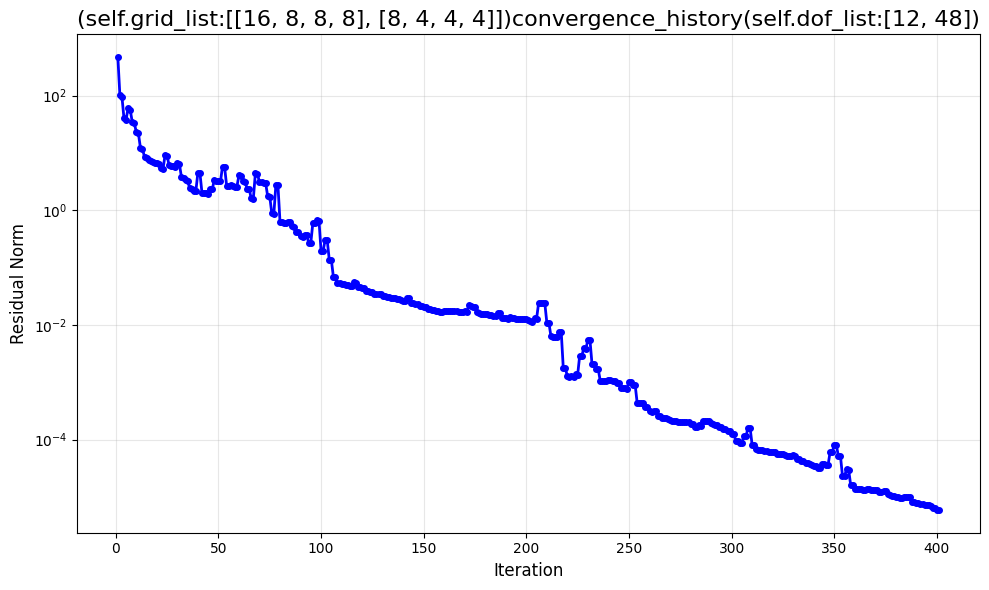

In [ ]:
mg.max_iter=200
mg.convergence_history=[]
x = mg.solve()
mg.plot()

In [ ]:
mg.lonv_list[0].shape

torch.Size([48, 12, 8, 2, 4, 2, 4, 2, 4, 2])

In [ ]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([-0.0032-0.0057j, -0.0029-0.0052j, -0.0018-0.0059j, -0.0031-0.0080j,
        -0.0033-0.0072j, -0.0050-0.0089j, -0.0052-0.0083j, -0.0053-0.0073j,
        -0.0039-0.0058j, -0.0017-0.0061j, -0.0015-0.0071j, -0.0025-0.0070j,
        -0.0020-0.0083j, -0.0034-0.0071j, -0.0054-0.0082j, -0.0043-0.0065j,
        -0.0026-0.0063j, -0.0020-0.0072j, -0.0019-0.0075j, -0.0016-0.0085j,
        -0.0030-0.0073j, -0.0051-0.0085j, -0.0044-0.0070j, -0.0050-0.0073j,
        -0.0049-0.0076j, -0.0035-0.0072j, -0.0028-0.0071j, -0.0040-0.0084j,
        -0.0046-0.0084j, -0.0042-0.0063j, -0.0058-0.0072j, -0.0052-0.0070j,
        -0.0053-0.0062j, -0.0049-0.0066j, -0.0044-0.0073j, -0.0042-0.0075j,
        -0.0058-0.0083j, -0.0048-0.0085j, -0.0055-0.0077j, -0.0062-0.0075j,
        -0.0060-0.0053j, -0.0047-0.0065j, -0.0043-0.0069j, -0.0039-0.0076j,
        -0.0054-0.0081j, -0.0077-0.0074j, -0.0065-0.0076j, -0.0066-0.0052j,
        -0.0044-0.0056j, -0.0051-0.0062j, -0.0041-0.0063j, -0.0039-0.0078j,
        -0.0

In [ ]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

0.26459238138944463


In [ ]:
mg.num_levels

2

In [ ]:
index = 0
null_vecs = mg.nv_list[index]
matvec = mg.op_list[index].matvec
for i in range(null_vecs.shape[0]):
    print(
        f"(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:{(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]}")

(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0127+0.0009j, 0.0115+0.0024j, 0.0124+0.0010j, 0.0099+0.0027j,
        0.0113+0.0015j, 0.0105+0.0037j, 0.0106+0.0026j, 0.0107+0.0031j,
        0.0111+0.0035j, 0.0120+0.0002j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0092+0.0129j, 0.0067+0.0165j, 0.0079+0.0131j, 0.0137+0.0125j,
        0.0090+0.0124j, 0.0084+0.0171j, 0.0121+0.0107j, 0.0049+0.0166j,
        0.0054+0.0141j, 0.0112+0.0121j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([ 0.0040-1.7449e-03j,  0.0046-2.4076e-03j,  0.0023+2.6649e-03j,
         0.0044-1.0376e-03j, -0.0008+1.9130e-03j,  0.0068+1.1741e-03j,
         0.0006+1.1736e-03j,  0.0056+1.6419e-03j,  0.0050+1.0781e-03j,
         0.0051-7.6727e-05j], device='cuda:0', dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0374+0.0321j, 0.0171+0.0388j, 0.0447

In [ ]:
mg.nv_list[-1].flatten()[:100]

tensor([0.0028-0.0021j, 0.0025-0.0019j, 0.0029-0.0019j, 0.0020-0.0023j,
        0.0025-0.0020j, 0.0022-0.0014j, 0.0020-0.0015j, 0.0023-0.0020j,
        0.0023-0.0018j, 0.0024-0.0027j, 0.0027-0.0024j, 0.0030-0.0019j,
        0.0026-0.0019j, 0.0027-0.0022j, 0.0021-0.0015j, 0.0020-0.0015j,
        0.0028-0.0020j, 0.0027-0.0022j, 0.0026-0.0024j, 0.0030-0.0024j,
        0.0027-0.0016j, 0.0024-0.0023j, 0.0021-0.0021j, 0.0024-0.0023j,
        0.0024-0.0022j, 0.0030-0.0018j, 0.0029-0.0025j, 0.0031-0.0020j,
        0.0025-0.0021j, 0.0028-0.0023j, 0.0024-0.0023j, 0.0025-0.0019j,
        0.0025-0.0024j, 0.0024-0.0021j, 0.0026-0.0027j, 0.0029-0.0026j,
        0.0022-0.0024j, 0.0024-0.0024j, 0.0027-0.0022j, 0.0029-0.0024j,
        0.0030-0.0019j, 0.0024-0.0023j, 0.0027-0.0023j, 0.0024-0.0022j,
        0.0021-0.0024j, 0.0024-0.0023j, 0.0033-0.0018j, 0.0031-0.0025j,
        0.0024-0.0020j, 0.0028-0.0019j, 0.0026-0.0019j, 0.0026-0.0019j,
        0.0026-0.0020j, 0.0028-0.0021j, 0.0029-0.0021j, 0.0032-0

In [ ]:
_null_vec = torch.randn_like(null_vecs[0])
print(torch.norm(matvec(_null_vec)))
print(matvec(_null_vec).flatten()[:20])
_null_vec -= inverse.bicgstab(b=matvec(_null_vec), matvec=matvec, tol=5e-5)
print(torch.norm(_null_vec))
print(_null_vec.flatten()[:20])
_null_vec/=torch.norm(_null_vec).item()
print(
    f"(matvec(_null_vec)/_null_vec).flatten()[:10]:{(matvec(_null_vec)/_null_vec).flatten()[:10]}")

tensor(351.6091, device='cuda:0', dtype=torch.float64)
tensor([-0.6016-1.0917j,  0.6633+1.7494j,  1.2805-1.5159j,  0.0932+0.8121j,
        -0.0374+0.4066j, -0.1779-1.2381j, -0.6059+0.1424j,  0.4829+0.4734j,
        -1.4583+0.5778j, -0.7709-0.8846j,  0.5729+0.4164j, -1.4836+0.1273j,
        -0.6176-0.7846j, -0.2078-0.2431j, -0.7570-2.2987j,  0.1645+0.6331j,
         0.1483+1.2084j,  0.7096-0.1945j, -0.2010-0.6282j,  1.1038-1.0743j],
       device='cuda:0', dtype=torch.complex128)
Norm of b:351.60909044223735
Norm of r:497.1571673758178
Norm of x0:314.3903073891829
BICGSTAB-Iteration 0: Residual = 8.581804e+01, Time = 0.006499 s
BICGSTAB-Iteration 1: Residual = 2.808947e+01, Time = 0.007000 s
BICGSTAB-Iteration 2: Residual = 4.421495e+01, Time = 0.006697 s
BICGSTAB-Iteration 3: Residual = 9.380193e+00, Time = 0.006697 s
BICGSTAB-Iteration 4: Residual = 6.414788e+00, Time = 0.006785 s
BICGSTAB-Iteration 5: Residual = 4.762678e+00, Time = 0.007073 s
BICGSTAB-Iteration 6: Residual = 1.00012

In [ ]:
_b = torch.randn_like(null_vecs[0])
_x = inverse.bicgstab(b=_b, matvec=matvec, tol=1e-8)
print((_b-matvec(_x)).flatten()[:100])
print(torch.norm(_b))
print(torch.norm(_x))

Norm of b:312.5443259166424
Norm of r:470.0059283745854
Norm of x0:312.96114950121364
BICGSTAB-Iteration 0: Residual = 1.011113e+02, Time = 0.006474 s
BICGSTAB-Iteration 1: Residual = 4.226800e+01, Time = 0.007541 s
BICGSTAB-Iteration 2: Residual = 4.668531e+01, Time = 0.006564 s
BICGSTAB-Iteration 3: Residual = 2.720696e+01, Time = 0.006469 s
BICGSTAB-Iteration 4: Residual = 1.714442e+01, Time = 0.007134 s
BICGSTAB-Iteration 5: Residual = 1.275181e+01, Time = 0.006893 s
BICGSTAB-Iteration 6: Residual = 1.230988e+01, Time = 0.006812 s


BICGSTAB-Iteration 7: Residual = 2.296488e+01, Time = 0.006884 s
BICGSTAB-Iteration 8: Residual = 1.287939e+01, Time = 0.006966 s
BICGSTAB-Iteration 9: Residual = 6.527925e+00, Time = 0.007204 s
BICGSTAB-Iteration 10: Residual = 7.553271e+00, Time = 0.006773 s
BICGSTAB-Iteration 11: Residual = 7.093086e+00, Time = 0.006534 s
BICGSTAB-Iteration 12: Residual = 5.385033e+00, Time = 0.006856 s
BICGSTAB-Iteration 13: Residual = 4.938611e+00, Time = 0.006838 s
BICGSTAB-Iteration 14: Residual = 4.514707e+00, Time = 0.006506 s
BICGSTAB-Iteration 15: Residual = 3.714238e+00, Time = 0.006798 s
BICGSTAB-Iteration 16: Residual = 2.965034e+00, Time = 0.006853 s
BICGSTAB-Iteration 17: Residual = 2.714987e+00, Time = 0.006815 s
BICGSTAB-Iteration 18: Residual = 2.343404e+00, Time = 0.007217 s
BICGSTAB-Iteration 19: Residual = 2.436244e+00, Time = 0.006643 s
BICGSTAB-Iteration 20: Residual = 2.363095e+00, Time = 0.006979 s
BICGSTAB-Iteration 21: Residual = 2.425383e+00, Time = 0.006784 s
BICGSTAB-Iter

In [ ]:
_null_vec.flatten()[:100]

tensor([-0.0046+1.0634e-03j, -0.0047+4.4476e-04j, -0.0053+3.2398e-04j,
        -0.0046+4.8086e-04j, -0.0050+7.6355e-04j, -0.0046+2.8278e-04j,
        -0.0045+1.7012e-04j, -0.0046+8.8582e-04j, -0.0049+7.8639e-04j,
        -0.0048+1.2339e-03j, -0.0049+4.9117e-04j, -0.0053+7.2649e-04j,
        -0.0047+1.4735e-04j, -0.0046+8.6404e-04j, -0.0050+5.0040e-04j,
        -0.0047+3.9405e-04j, -0.0051+3.0287e-04j, -0.0050+1.1255e-03j,
        -0.0048+8.3360e-04j, -0.0046+8.1974e-04j, -0.0045+1.7539e-04j,
        -0.0043+8.6763e-04j, -0.0048+1.0179e-03j, -0.0051+9.1936e-04j,
        -0.0049+6.7074e-04j, -0.0051+8.0037e-04j, -0.0048+1.1567e-03j,
        -0.0046+9.9737e-04j, -0.0046+4.0251e-04j, -0.0048+1.0113e-03j,
        -0.0048+7.4636e-04j, -0.0052+7.4050e-04j, -0.0051+6.8467e-04j,
        -0.0051+3.8472e-04j, -0.0050+1.0979e-03j, -0.0049+1.4709e-03j,
        -0.0044+5.1524e-04j, -0.0048+4.1280e-04j, -0.0045+1.0531e-03j,
        -0.0049+9.7574e-04j, -0.0053+8.6139e-04j, -0.0049+7.0695e-04j,
      